In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn import linear_model
import lightgbm as lgb
from scipy.optimize import differential_evolution

### Load Data and Train Model

In [10]:
# import the cement_data.csv file
df = pd.read_csv('../database/concrete_data.csv')

print(df.columns)

import warnings
import numpy as np

# Remove outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


X = df[["age","cement"]]
y = df["concrete_compressive_strength"]

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# lr = linear_model.LinearRegression()
# model_lr = lr.fit(X_train, y_train)
# y_pred = model_lr.predict(X_test)
# rmse = np.sqrt(root_mean_squared_error(y_pred=y_pred,y_true=y_test))
# r2 = r2_score(y_pred=y_pred,y_true=y_test)
# print(f"RMSE:{rmse}\nR-Squared:{r2}")

lgbm = lgb.LGBMRegressor(verbose=-1)
model_lgbm = lgbm.fit(X_train, y_train)
y_pred = model_lgbm.predict(X_test)
rmse = np.sqrt(root_mean_squared_error(y_pred=y_pred, y_true=y_test))
r2 = r2_score(y_pred=y_pred, y_true=y_test)
print(f"RMSE:{rmse}\nR-Squared:{r2}")

Index(['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer',
       'coarse_aggregate', 'fine_aggregate ', 'age',
       'concrete_compressive_strength'],
      dtype='object')
RMSE:2.91715403906172
R-Squared:0.721454732930938


### Setup Optimization Model

In [11]:
# Use differential evolution to maximize the compression strength
def maximize_obj_func_lgbm(x):
    return -model_lgbm.predict([x])

def maximize_obj_func_lr(x):
    return -model_lr.predict([x])


def run_optimizer(x,y,model):
    bounds = [(df[x].min(), df[x].max()), (df[y].min(), df[y].max())]
    iterations_data = []
    def callback_lgbm(xk, convergence):
        # Store information at each iteration
        iterations_data.append({
            'iteration': len(iterations_data) + 1,        # Store the iteration number
            'solution': np.copy(xk),                      # Store a copy of the solution
            'objective_value': maximize_obj_func_lgbm(xk),    # Store the objective function value at the current solution
            'convergence': convergence                    # Store the convergence value
        })
    def callback_lr(xk, convergence):
        # Store information at each iteration
        iterations_data.append({
            'iteration': len(iterations_data) + 1,        # Store the iteration number
            'solution': np.copy(xk),                      # Store a copy of the solution
            'objective_value': maximize_obj_func_lr(xk),    # Store the objective function value at the current solution
            'convergence': convergence                    # Store the convergence value
        })
        
    if model == "model_lgbm":
        result = differential_evolution(maximize_obj_func_lgbm, bounds,callback=callback_lgbm)
    elif model == "model_lr":
        result = differential_evolution(maximize_obj_func_lr, bounds,callback=callback_lr)

    optimized_x = result.x[0]
    optimized_y = result.x[1]
    optimized_obj = -result.fun

    print(f"Optimized X: {optimized_x}")
    print(f"Optimized Y: {optimized_y}")
    print(f"Optimized Strength: {optimized_obj}")

    return optimized_x,optimized_y,optimized_obj,iterations_data

In [29]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def plot_optimized_obj_func(x_values, y_values, model):

    # Run the optimizer
    output = run_optimizer(x_values, y_values, model)

    # Create a grid of x and y values for the surface plot
    x_grid = df[x_values]
    y_grid = df[y_values]
    x_grid, y_grid = np.meshgrid(x_grid, y_grid)
    # Use the trained model to predict z values for the grid
    if model == "model_lgbm":
        z_grid = model_lgbm.predict(
            np.column_stack((x_grid.ravel(), y_grid.ravel()))
        ).reshape(x_grid.shape)
    elif model == "model_lr":
        z_grid = model_lr.predict(
            np.column_stack((x_grid.ravel(), y_grid.ravel()))
        ).reshape(x_grid.shape)

    plt.figure(figsize=(5, 3))
    fig = make_subplots(rows=1, cols=1, specs=[[{"type": "surface"}]])

    # Add the surface plot
    surface = go.Surface(
        x=x_grid, y=y_grid, z=z_grid, colorscale="Viridis", opacity=0.7
    )
    fig.add_trace(surface)

    # Add the scatter plot for the optimized point
    scatter = go.Scatter3d(
        x=[output[0]],
        y=[output[1]],
        z=[output[2]],
        mode="markers",
        marker=dict(size=5, color="red"),
        name="Optimized Point",
    )
    fig.add_trace(scatter)

    # Set labels and title
    fig.update_layout(
        scene=dict(
            xaxis_title=f"{x_values}",
            yaxis_title=f"{y_values}",
            zaxis_title="Concrete Compressive Strength",
        ),
        width=500,
        height=500,
        title=f"3D Plot of Model Predictions using {model}",
        margin=dict(l=45, r=30, b=45, t=70),
    )

    # Show the plot
    fig.show()

    print(f"Optimized X: {output[0]}")
    print(f"Optimized Y: {output[1]}")
    print(f"Optimized Obj: {output[2]}")

    iteration = output[3]
    # Extract the convergence values
    convergence = [data["convergence"] for data in iteration]

    # Extract the solution values
    solution = [data["solution"] for data in iteration]

    # Extract the objective function values
    objective_values = [data["objective_value"] for data in iteration]

    # Plot the solution values and convergence values
    plt.figure(figsize=(5, 3))
    plt.plot(convergence)
    plt.title("Convergence Plot")
    plt.xlabel("Iteration")
    plt.ylabel("Convergence Value")
    plt.grid(True)
    plt.show()

    # Plot the solution values and convergence values
    plt.figure(figsize=(5, 3))
    plt.plot(solution)
    plt.title("Convergence of Decision Variables")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.grid(True)
    plt.show()

    # Plot the solution values and convergence values
    plt.figure(figsize=(5, 3))
    plt.plot(objective_values)
    plt.title("Convergence of Objective Function Values")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.grid(True)
    plt.show()

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_optimized_obj_func(x_values, y_values, model):
    # Run the optimizer
    output = run_optimizer(x_values, y_values, model)

    # Create a grid of x and y values for the surface plot
    x_grid = df[x_values]
    y_grid = df[y_values]
    x_grid, y_grid = np.meshgrid(x_grid, y_grid)

    # Use the trained model to predict z values for the grid
    if model == "model_lgbm":
        z_grid = model_lgbm.predict(
            np.column_stack((x_grid.ravel(), y_grid.ravel()))
        ).reshape(x_grid.shape)
    elif model == "model_lr":
        z_grid = model_lr.predict(
            np.column_stack((x_grid.ravel(), y_grid.ravel()))
        ).reshape(x_grid.shape)

    # Create a surface plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(x_grid, y_grid, z_grid, cmap="viridis", alpha=0.7)

    # Add the scatter plot for the optimized point
    ax.scatter(
        output[0], output[1], output[2], color="red", s=50, label="Optimized Point"
    )

    # Set labels and title
    ax.set_xlabel(f"{x_values}")
    ax.set_ylabel(f"{y_values}")
    ax.set_zlabel("Concrete Compressive Strength")
    ax.set_title(f"3D Plot of Model Predictions using {model}")
    ax.legend()

    # Show the plot
    plt.show()

    iteration = output[3]
    # Extract the convergence values
    convergence = [data["convergence"] for data in iteration]

    # Extract the solution values
    solution = [data["solution"] for data in iteration]

    # Extract the objective function values
    objective_values = [data["objective_value"] for data in iteration]

    # Plot the convergence values
    plt.figure(figsize=(5, 3))
    plt.plot(convergence)
    plt.title("Convergence Plot")
    plt.xlabel("Iteration")
    plt.ylabel("Convergence Value")
    plt.grid(True)
    plt.show()

    # Plot the solution values
    plt.figure(figsize=(5, 3))
    plt.plot(solution)
    plt.title("Convergence of Decision Variables")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.grid(True)
    plt.show()

    # Plot the objective function values
    plt.figure(figsize=(5, 3))
    plt.plot(objective_values)
    plt.title("Convergence of Objective Function Values")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.grid(True)
    plt.show()

### Plot Results

Optimized X: 90.64178336042875
Optimized Y: 364.82311220169
Optimized Strength: 77.69398408196385


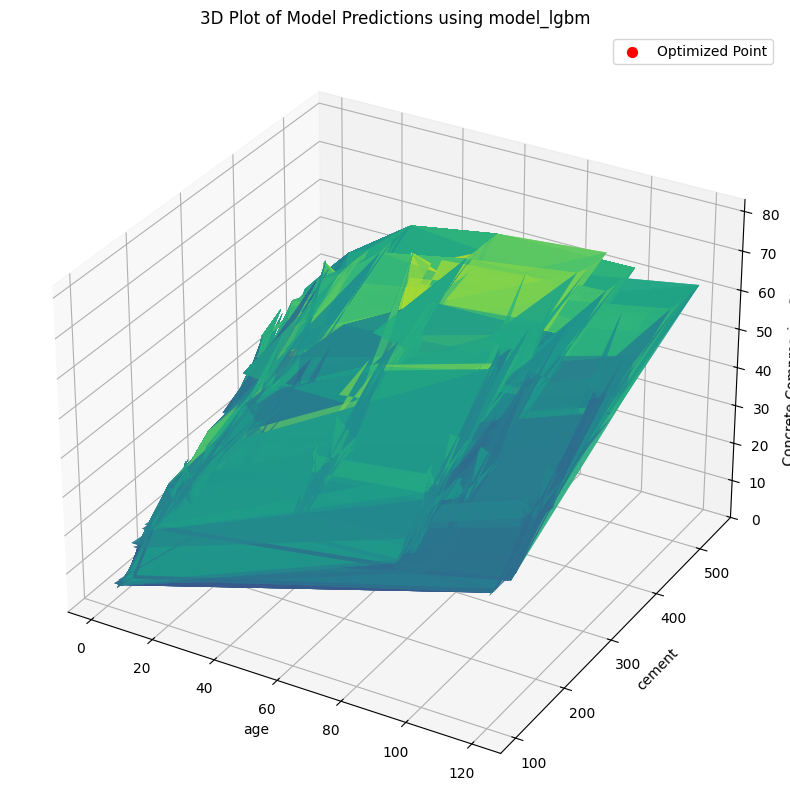

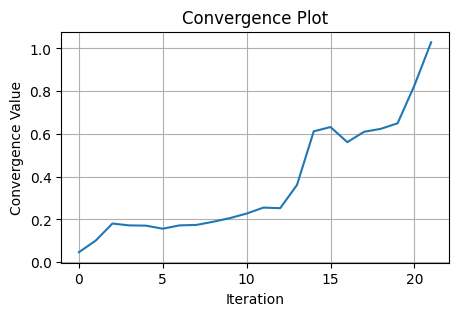

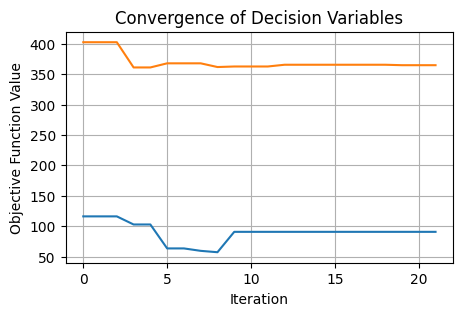

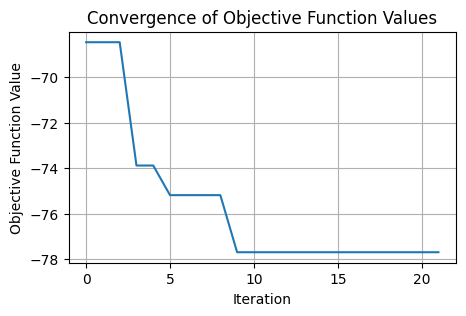

In [37]:
plot_optimized_obj_func("age","cement","model_lgbm")